In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

#import metpy.calc as mpcalc
#from metpy.plots import SkewT
#from metpy.units import units

# Functions, data

In [2]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfpout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [3]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[-1]]-pressure[idxs[0]])
    except IndexError :
        print("Column only contains nans")
        return np.nan
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [4]:
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[[vdim],[vdim]],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

In [5]:
def add_text(ax):
    ax.text(0.1, 0.1,'EAST (upstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")
    ax.text(0.9, 0.1,'WEST (downstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")

In [6]:
def rad_cooling(sim):
    mSWUPT = (sim.ACSWUPT.isel(Time = -1)-sim.ACSWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = -1)-sim.ACSWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = -1)-sim.ACSWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = -1)-sim.ACSWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = -1)-sim.ACLWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = -1)-sim.ACLWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = -1)-sim.ACLWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = -1)-sim.ACLWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB

In [7]:
%%time
channel10 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.100km.300d/",nfiles=17)
channel3 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_3mps.wrf.100x10.mountain.100km.180d/",nfiles=17)
#channel10_p = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/processed/channel.wrf.100x10.mountain.100km.300d/",nfiles=30)


CPU times: user 26.7 s, sys: 28.1 s, total: 54.8 s
Wall time: 28.2 s


In [8]:
%%time
hrchannel10 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km.300d/")
hrchannel3 = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3mps.3km.300d/")

CPU times: user 9.85 s, sys: 4.11 s, total: 14 s
Wall time: 26.8 s


In [9]:
hrchannel10_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km.300d/')
hrchannel3_p = extract_wrfpro('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3mps.3km.300d/')

In [9]:
hgt = channel10.HGT.isel(south_north=0,Time=-1).persist()
dist=(50-hgt.west_east)*100
def plotsection():
    fig, ax = plt.subplots(1,1,figsize=(15,4))
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot(dist,hgt,color='k')
    return ax,ax.twinx()

In [10]:
hrhgt = hrchannel10.HGT.isel(south_north=0,Time=-1).persist()
hrdist=(1635-hrhgt.west_east)*3
def plothrsection():
    fig, ax = plt.subplots(1,1,figsize=(15,4))
    ax.set_xlabel("distance west of mountain top (km)")
    ax.set_ylabel("height(m)")
    ax.plot(hrdist,hrhgt,color='k')
    return ax,ax.twinx()

In [11]:
from wrf import cape_2d
import wrf
from netCDF4 import Dataset
from joblib import Parallel, delayed

def compute_individual_cape(file):
    return wrf.getvar(Dataset(file), "cape_2d", timeidx=wrf.ALL_TIMES)

num_cores = 16
wrf.omp_set_num_threads(32)
def compute_cape(simulation_path,nfiles=None):
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    if nfiles:
        files=files[:nfiles]
    capecin_list = Parallel(n_jobs=num_cores)(delayed(compute_individual_cape)(file) for file in files)
    return xr.combine_nested(capecin_list,concat_dim='Time')

In [ ]:
%time channel10capecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.100km.300d/",nfiles=17)
%time channel3capecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_3mps.wrf.100x10.mountain.100km.180d/")
channel10CAPEmean = channel10capecin.isel(mcape_mcin_lcl_lfc=0,Time=slice(400,2400)).mean('Time')
channel3CAPEmean = channel3capecin.isel(mcape_mcin_lcl_lfc=0,Time=slice(400,2400)).mean('Time')

In [ ]:
#%%time
##Takes 1 hour
#capecin_list=[]
#for file in sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3mps.3km.300d/wrfout*'))[11:]:
#    print(file)
#    c = compute_individual_cape(file)
#    del(c.attrs['projection'])
#    c.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3mps.3km.300d/diags/wrf.cape.'+file[-19:]+'.nc')
    

In [13]:

hrchannel10_capecin=xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km.300d/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d
hrchannel3_capecin =xr.open_mfdataset(sorted(glob.glob('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3mps.3km.300d/diags/wrf.cape.*')),combine='nested',concat_dim='Time',parallel=True).cape_2d




# Coarse runs analysis

## Lon-lev cross sections

In [12]:
w = channel10.W.isel(Time=slice(200,680)).mean(["Time","south_north"])
w_plot=w.assign_coords({'distance_from_mtn':(49-w.west_east)*100,'eta_level':channel10.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()

Text(0.5, 1.0, 'Moist, coarse simulation - W (nonlinear scale)')

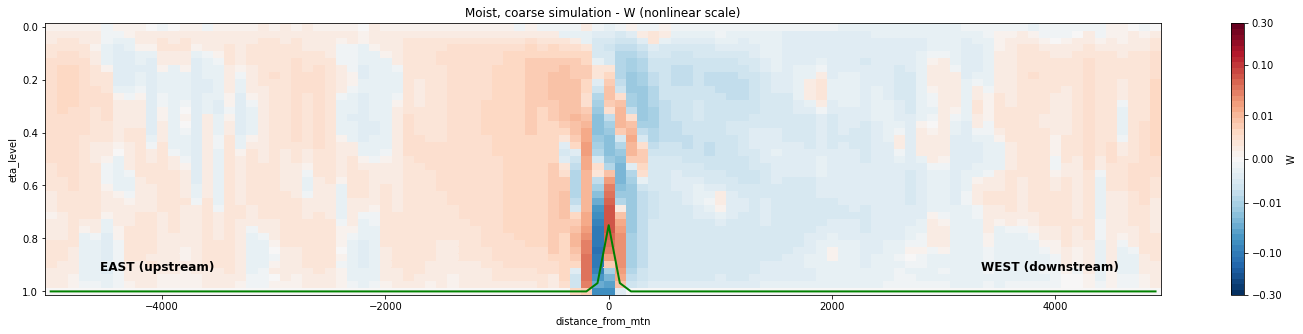

In [13]:
_,ax=plt.subplots(1,1,figsize=(25,5))
w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(w_plot.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("Moist, coarse simulation - W (nonlinear scale)")


In [14]:
w = channel3.W.isel(Time=slice(200,680)).mean(["Time","south_north"])
w_plot=w.assign_coords({'distance_from_mtn':(49-w.west_east)*100,'eta_level':channel10.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()

Text(0.5, 1.0, 'Moist, coarse simulation - W (nonlinear scale) - 3m/s')

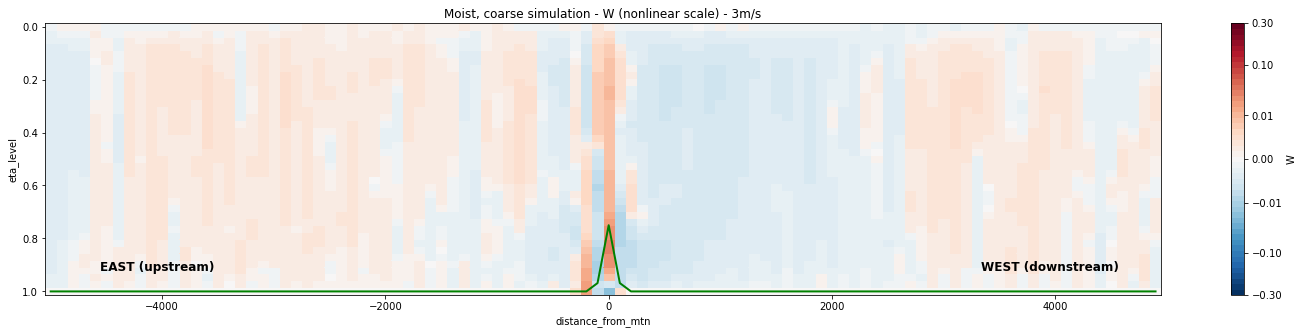

In [16]:
_,ax=plt.subplots(1,1,figsize=(25,5))
w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(w_plot.distance_from_mtn, 1-hgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("Moist, coarse simulation - W (nonlinear scale) - 3m/s")


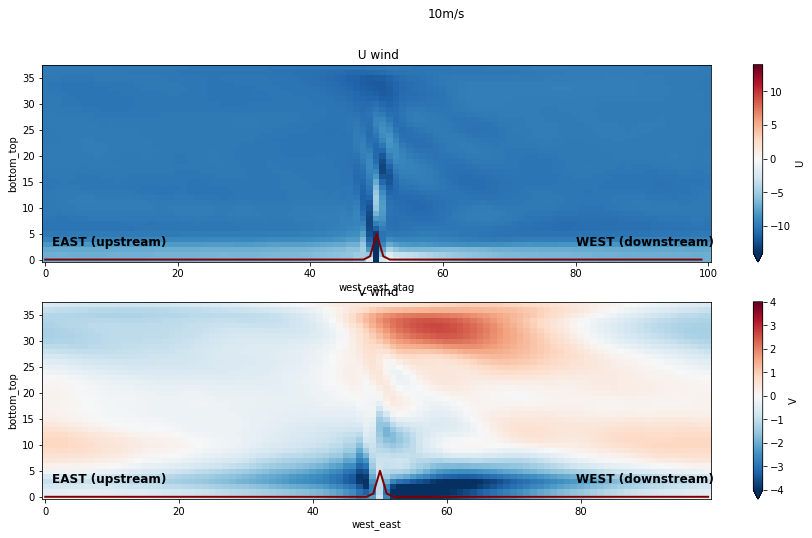

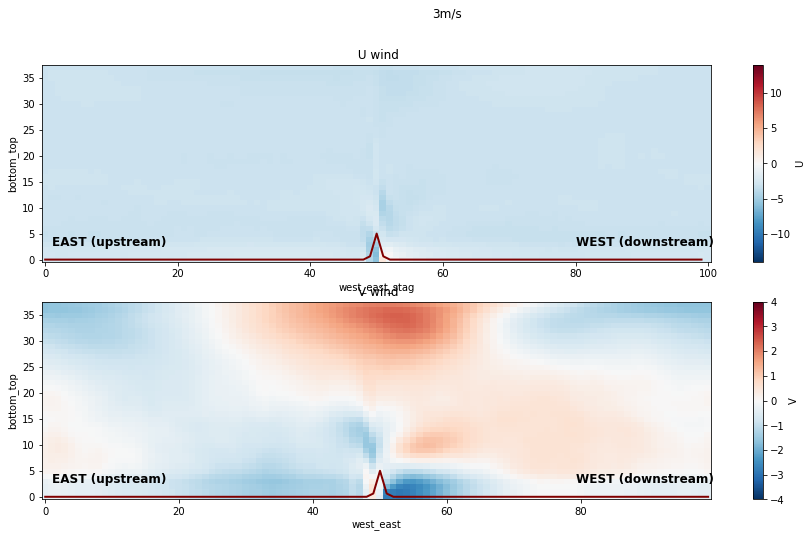

In [24]:
def plotuv(sim,desc):
    fig,ax=plt.subplots(2,1,figsize=(15,8))
    ax=ax.reshape(-1)
    i=0
    
    sim.U.isel(Time=slice(200,680)).mean(["Time","south_north"])[:,::-1].plot(ax=ax[0], x='west_east_stag',vmin=-14,vmax=14,cmap=plt.cm.RdBu_r)
    sim.V.isel(Time=slice(200,680)).mean(["Time","south_north_stag"])[:,::-1].plot(ax=ax[1], x='west_east',vmin=-4,vmax=4,cmap=plt.cm.RdBu_r)
    
    ax[0].plot(sim.west_east, sim.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)
    ax[1].plot(sim.west_east, sim.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)
    
    ax[0].set_title(" U wind")
    ax[1].set_title(" V wind")
    
    for a in ax:
        add_text(a)
    fig.suptitle(desc)

plotuv(channel10,"10m/s")
plotuv(channel3,"3m/s")

    

## Precip,Cape

In [26]:
%%time
channel10precip = 4*(channel10.RAINC+channel10.RAINNC).isel(Time=slice(200,680)).diff('Time').persist()
channel3precip = 4*(channel3.RAINC+channel3.RAINNC).isel(Time=slice(200,680)).diff('Time').persist()


CPU times: user 472 ms, sys: 81.2 ms, total: 553 ms
Wall time: 2.49 s


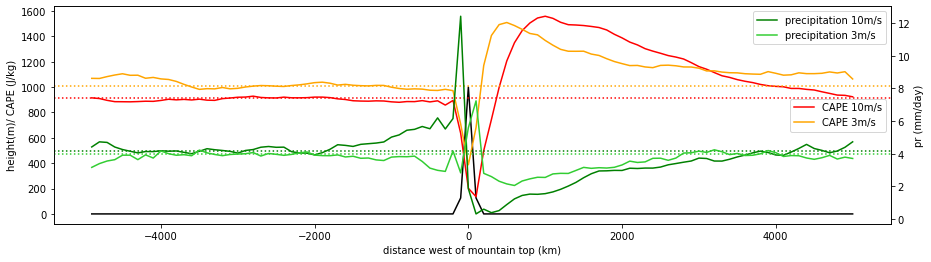

In [42]:
ax,ax2=plotsection()
ax.set_ylabel("height(m)/ CAPE (J/kg)")
ax.plot(dist,channel10CAPEmean.mean('south_north'),color='r',label='CAPE 10m/s')
ax.axhline(channel10CAPEmean.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='r',linestyle=':')

ax2.set_ylabel("pr (mm/day)")
ax2.plot(dist,channel10precip.mean(['south_north','Time']),color='green',label='precipitation 10m/s')
ax2.axhline(channel10precip.isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='g',linestyle=':')


ax.plot(dist,channel3CAPEmean.mean('south_north'),color='orange',label='CAPE 3m/s')
ax.axhline(channel3CAPEmean.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='orange',linestyle=':')
ax2.plot(dist,channel3precip.mean(['south_north','Time']),color='limegreen',label='precipitation 3m/s')
ax2.axhline(channel3precip.isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='limegreen',linestyle=':')

ax.legend(loc="center right")
ax2.legend()


# High res runs analysis

## Lon-lev cross sections

In [14]:
%%time
#hr10w = hrchannel10.isel(Time=slice(200,801)).W.mean(["Time","south_north"])
hr10w = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km.300d/diags/wrf.W.days50-200.nc")
hr10w_plot=hr10w.assign_coords({'distance_from_mtn':(1635-hr10w.west_east)*3,'eta_level':hrchannel10.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()


CPU times: user 17.1 ms, sys: 0 ns, total: 17.1 ms
Wall time: 55.9 ms


Text(0.5, 1.0, 'Moist, high res simulation - W (nonlinear scale) - u=10m/s')

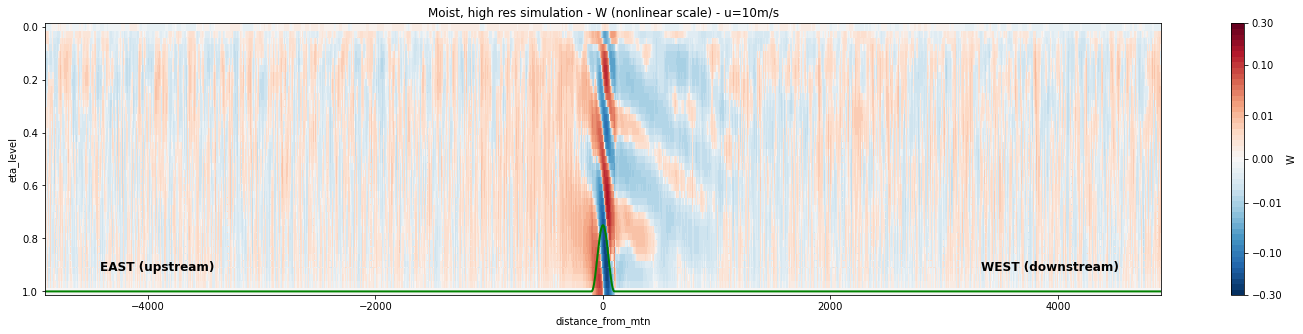

In [15]:
_,ax=plt.subplots(1,1,figsize=(25,5))
hr10w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hr10w_plot.distance_from_mtn, 1-hrhgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("Moist, high res simulation - W (nonlinear scale) - u=10m/s")


In [16]:
%%time
hr3w = hrchannel3.W.isel(Time=slice(200,801)).mean(["Time","south_north"])
hr3w_plot=hr3w.assign_coords({'distance_from_mtn':(1635-hr3w.west_east)*3,'eta_level':hrchannel3.ZNW.isel(Time=-1)}).swap_dims({'bottom_top_stag':'eta_level','west_east':'distance_from_mtn'}).persist()


CPU times: user 25.3 s, sys: 55.9 s, total: 1min 21s
Wall time: 1min 4s


In [17]:
hr3w.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3mps.3km.300d/diags/wrf.W.days50-200.nc")


Text(0.5, 1.0, 'Moist, high res simulation - W (nonlinear scale) - u=3m/s')

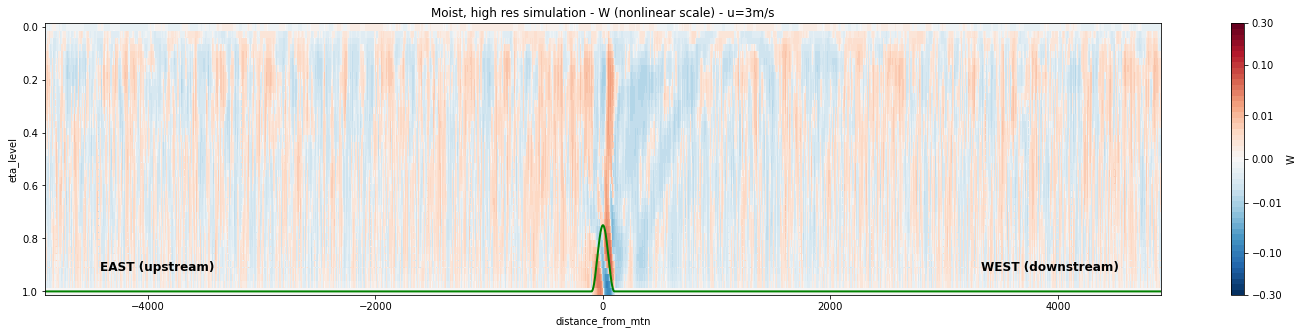

In [32]:
_,ax=plt.subplots(1,1,figsize=(25,5))
hr3w_plot.plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hr3w_plot.distance_from_mtn, 1-hrhgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("Moist, high res simulation - W (nonlinear scale) - u=3m/s")


Text(0.5, 1.0, 'Moist, high res simulation - W (nonlinear scale) - u=3m/s')

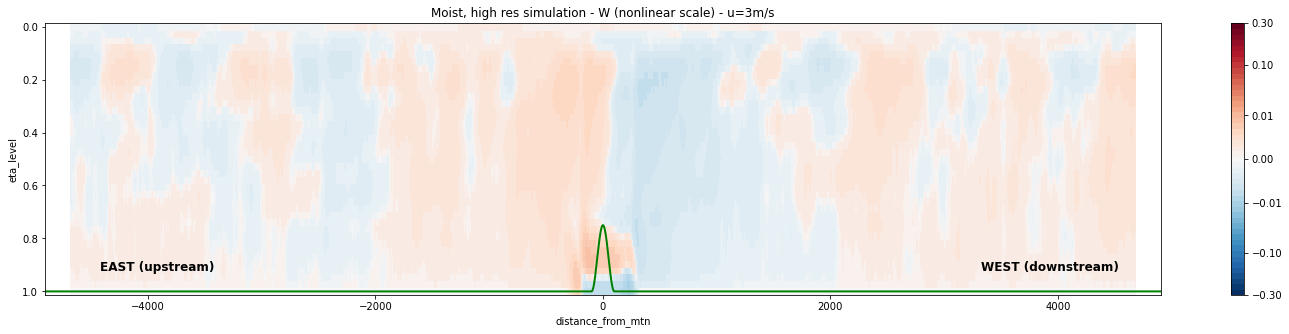

In [33]:
_,ax=plt.subplots(1,1,figsize=(25,5))
hr3w_plot.rolling(distance_from_mtn=151, center=True).mean().plot(ax=ax, x='distance_from_mtn',yincrease=False, levels=np.linspace(-(0.3)**(1/3),0.3**(1/3),50)**3,cbar_kwargs={'ticks':[-.3,-.1,-.01,0.,.01,.1,.3]})
ax.plot(hr3w_plot.distance_from_mtn, 1-hrhgt/4000,color='g',linewidth=2)
add_text(ax)
ax.set_title("Moist, high res simulation - W (nonlinear scale) - u=3m/s")




## Precip,Cape

In [18]:
hrchannel10precip = xr.open_dataarray("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km.300d/diags/wrf.precip.days0-200.nc")

In [19]:
%%time
hrchannel3precip = 4*(hrchannel3.RAINC+hrchannel3.RAINNC).diff('Time').persist()


CPU times: user 160 ms, sys: 2min 21s, total: 2min 22s
Wall time: 3min 8s


In [20]:
hrchannel3precip.to_netcdf("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3mps.3km.300d/diags/wrf.precip.days0-200.nc")



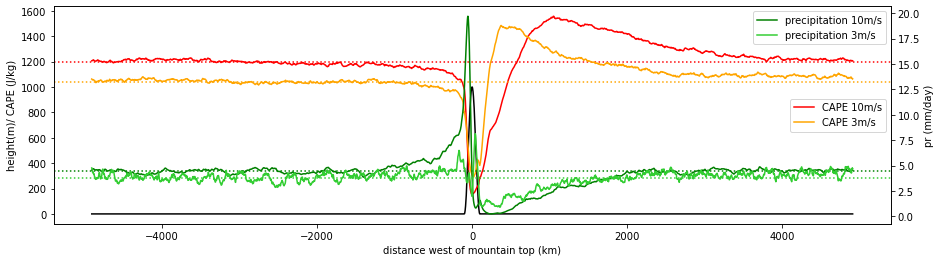

In [21]:
ax,ax2=plothrsection()
ax.set_ylabel("height(m)/ CAPE (J/kg)")

ax.plot(hrdist,hrchannel10_capecin[0].mean(['south_north','Time']),color='r',label='CAPE 10m/s')
ax.axhline(hrchannel10_capecin[0].isel(west_east=slice(2000,3000)).mean(),color='r',linestyle=':')

ax.plot(hrdist,hrchannel3_capecin[0].mean(['south_north','Time']),color='orange',label='CAPE 3m/s')
ax.axhline(hrchannel3_capecin[0].isel(west_east=slice(2000,3000)).mean(),color='orange',linestyle=':')

ax2.set_ylabel("pr (mm/day)")

ax2.plot(hrdist,hrchannel10precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='green',label='precipitation 10m/s')
ax2.axhline(hrchannel10precip.isel(Time=slice(200,801),west_east=slice(2000,3000)).mean(),color='g',linestyle=':')

ax2.plot(hrdist,hrchannel3precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='limegreen',label='precipitation 3m/s')
ax2.axhline(hrchannel3precip.isel(Time=slice(200,801),west_east=slice(2000,3000)).mean(),color='limegreen',linestyle=':')


ax.legend(loc="center right")
ax2.legend()


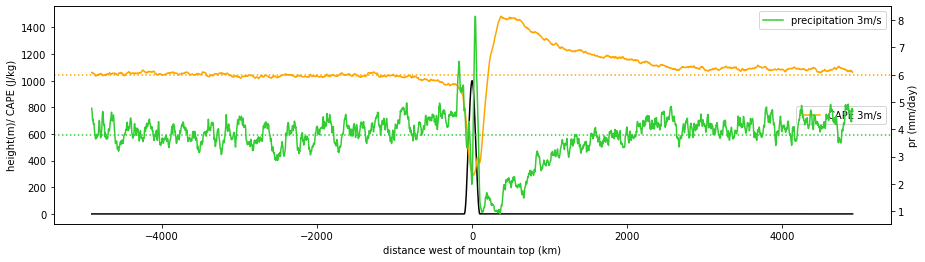

In [27]:
ax,ax2=plothrsection()
ax.set_ylabel("height(m)/ CAPE (J/kg)")

ax.plot(hrdist,hrchannel3_capecin[0].mean(['south_north','Time']),color='orange',label='CAPE 3m/s')
ax.axhline(hrchannel3_capecin[0].isel(west_east=slice(2000,3000)).mean(),color='orange',linestyle=':')

ax2.set_ylabel("pr (mm/day)")

ax2.plot(hrdist,hrchannel3precip.isel(Time=slice(200,801)).mean(['south_north','Time']),color='limegreen',label='precipitation 3m/s')
ax2.axhline(hrchannel3precip.isel(Time=slice(200,801),west_east=slice(2000,3000)).mean(),color='limegreen',linestyle=':')


ax.legend(loc="center right")
ax2.legend()


No handles with labels found to put in legend.


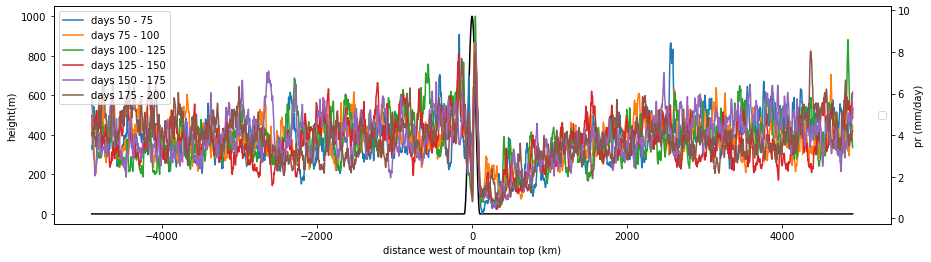

In [22]:
ax,ax2=plothrsection()

#for i in range(5,10):
#    ax.plot(hrdist ,hrchannel3_capecin[0].isel(Time=slice(40*i,40*(i+1))).mean(['south_north','Time']),label='CAPE - days %i - %i'%(10*i,10*(i+1)))

n=25

ax2.set_ylabel("pr (mm/day)")
for i in range(2,8):
    ax2.plot(hrdist ,hrchannel3precip.isel(Time=slice(4*n*i,4*n*(i+1))).mean(['south_north','Time']),label='days %i - %i'%(n*i,n*(i+1)))#,color='green',label='precipitation')
ax.legend(loc="center right")
ax2.legend()

## Analytical theory on 3m/s run

In [23]:
def compute_msmh(omega,t,z,q):
    s=slices[i][0]
    s0,s1 = 1635-s[0]//3,1635-s[1]//3
    
    Cp=1004.
    Lv=2.26e6
    g=9.81
    press=hrchannel_p.P_PL.isel(Time=-1).load()
    
    t     = tmean.isel(west_east=slice(s1,s0)).mean("west_east").persist().assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
    z     = zmean.isel(west_east=slice(s1,s0)).mean("west_east").persist().assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
    q     = qmean.isel(west_east=slice(s1,s0)).mean("west_east").persist().assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
    if rol :
        omega = omegamean.rolling(west_east=101, center=True).mean().isel(west_east=slice(s1,s0)).mean("west_east").persist().assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
    else :
        omega = omegamean.isel(west_east=slice(s1,s0)).mean("west_east").persist().assign_coords({"pressure":press/100}).swap_dims({"num_press_levels_stag":"pressure"})[1:-4]
    
    omega = omega/omega.mean()

    s = (Cp*t+g*z).load()
    h = (s + Lv*q).load()
    
    Ms=pressure_mean(omega*s.differentiate("pressure",edge_order=2)/100.)
    Mh=pressure_mean(omega*h.differentiate("pressure",edge_order=2)/100.)
    print(slices[i][1], "%.1f"%(Ms/Mh))
    
    if plot:
        _,ax=plt.subplots(1,1,figsize=(7,7))
        ax2=ax.twiny()
        ax.plot(omega/np.max(omega),omega.pressure, label="omega (rescaled)")
        #ax2.plot(s,omega.pressure, label="s",color='g')
        ax2.plot(h,omega.pressure, label="h",color='r')
        omegadsdp=omega*s.differentiate("pressure",edge_order=2)
        omegadhdp=omega*h.differentiate("pressure",edge_order=2)
        #ax.plot(-np.sign(omegadsdp.mean())*omegadsdp/omegadsdp.mean(),omega.pressure,color='limegreen', label="-omega*ds/dp (rescaled)")
        #ax.plot(-np.sign(omegadhdp.mean())*omegadhdp/omegadhdp.mean(),omega.pressure,color='orange', label="-omega*dh/dp (rescaled)")
        ax.plot(-omegadhdp/np.max(-omegadhdp),omega.pressure,color='orange', label="-omega*dh/dp (rescaled)")
        ax.set_ylim(1000,100)
        ax2.set_ylim(1000,100)
        ax.legend()
        ax2.legend()
        ax.axvline(0,linestyle='dotted',color='k')
        ax.set_title(slices[i][1])
    
    return Ms,Mh

In [24]:
hr3_upstream = hr3w_plot.sel(distance_from_mtn=slice(-500,-2000)).mean('distance_from_mtn')

In [25]:
hr3_allbutmtn = (hr3w_plot.sel(distance_from_mtn=slice(4800,3000)).mean('distance_from_mtn')+hr3w_plot.sel(distance_from_mtn=slice(-2000,-4900)).mean('distance_from_mtn'))/2

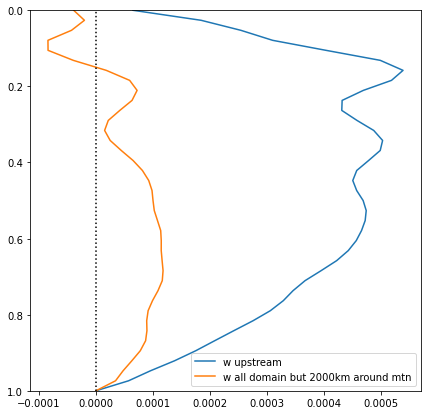

In [26]:
_,ax=plt.subplots(1,1,figsize=(7,7))
ax.plot(hr3_upstream,hr3_upstream.eta_level, label="w upstream")
ax.plot(hr3_allbutmtn,hr3_allbutmtn.eta_level, label="w all domain but 2000km around mtn")
ax.legend()
ax.set_ylim(1,0)
ax.axvline(0,linestyle='dotted',color='k')

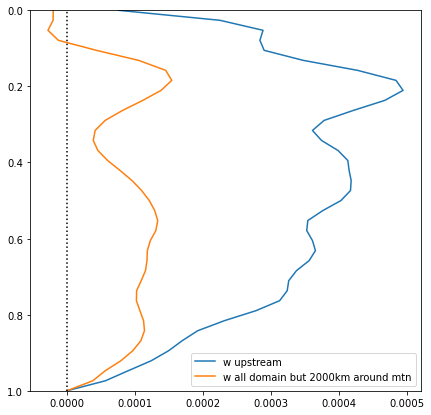

In [52]:
_,ax=plt.subplots(1,1,figsize=(7,7))
ax.plot(hr3_upstream,hr3_upstream.eta_level, label="w upstream")
ax.plot(hr3_allbutmtn,hr3_allbutmtn.eta_level, label="w all domain but 2000km around mtn")
ax.legend()
ax.set_ylim(1,0)
ax.axvline(0,linestyle='dotted',color='k')